<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Import Libraries
</h1>

In [9]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, auc, classification_report, 
                             confusion_matrix, precision_score, recall_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Imbalanced-Learn Library
from imblearn.under_sampling import RandomUnderSampler


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Loading the Dataset
</h1>

In [10]:
# Loading the clean dataset from ANN classification
df = pd.read_csv('classification_cleaned.csv')

In [11]:
df.head(10)

,alpha,delta,cam_col,class,redshift,plate,MJD,photometric_filters
0,135.689107,32.494632,2,0,0.634794,5812,56354,21.431178
1,144.826101,31.274185,5,0,0.779136,10445,58158,22.923626
2,142.188790,35.582444,2,0,0.644195,4576,55592,22.010612
3,338.741038,-0.402828,3,0,0.932346,9149,58039,21.773891
4,345.282593,21.183866,3,0,0.116123,6121,56187,17.387107
5,340.995121,20.589476,3,1,1.424659,5026,55855,22.010586
6,23.234926,11.418188,2,1,0.586455,11069,58456,21.023539
7,5.433176,12.065186,2,0,0.477009,6183,56210,20.948755
8,200.290475,47.199402,5,0,0.660012,6625,56386,21.709317
9,39.149691,28.102842,4,2,-0.000008,2444,54082,19.991768


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Preprocessing the Dataset
</h1>

In [12]:
# create X and y
X = df.drop('class', axis=1)
y = df['class']

In [13]:
# Checking the distribution of the classes
df['class'].value_counts()

class
0    59445
2    21594
1    18961
Name: count, dtype: int64

In [14]:
# Using the under-sampling method to balance the values of the class column as you can see it previously. all those three values are not balanced
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)


In [15]:
# after using the under-sampling method, lt's check the value counts of the 'class' column
pd.Series(y).value_counts()

class
0    18961
1    18961
2    18961
Name: count, dtype: int64

In [16]:
print(f"X data samples: {len(X)}")
print(f"y data samples: {len(y)}")

X data samples: 56883
y data samples: 56883


In [17]:
# Splitting the data into train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)


In [18]:
# Displaying the number of samples in each data split
print(f"Training data samples: {len(X_train)}")
print(f"Test data samples: {len(X_test)}")

Training data samples: 39818
Test data samples: 17065


In [19]:
# Displaying the shape of each data split (features and target variables)
print(f"Training set (X_train): {X_train.shape}, Target (y_train): {y_train.shape}")
print(f"Test set (X_test): {X_test.shape}, Target (y_test): {y_test.shape}")

Training set (X_train): (39818, 7), Target (y_train): (39818,)
Test set (X_test): (17065, 7), Target (y_test): (17065,)


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Random Forest Classifier
</h1>

In [20]:
# I am going to create a DataFrame to store the results of Random Forest for 5 neighbors.
# I will sort them and observe at which number of neighbors the highest score is achieved.
rforest_top = pd.DataFrame(columns=['Neighbors', 'Test Accuracy'])

for i in range(1, 21):
    rforest = RandomForestClassifier(n_estimators=i, random_state=42)
    rforest.fit(X_train, y_train)
    y_pred = rforest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rforest_top.loc[len(rforest_top)] = [i, accuracy]

# Sort the results by test accuracy in descending order
rforest_top.sort_values(by = "Test Accuracy", ascending=False).head(5).reset_index( drop = True)

,Neighbors,Test Accuracy
0,20.0,0.963141
1,19.0,0.963141
2,15.0,0.962555
3,18.0,0.962496
4,16.0,0.962496


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; border: 2px solid #a9a9a9;">
  <h2 style="color: #4b0082;">Personal Analysis</h2>
  <p style="font-size: 16px; color: #000000;">I found the test accuracy of top 5  values of the <code>n_estimators</code> parameter in the Random Forest classifier and stored the results in a DataFrame. The  shows the test accuracy for each <code>n_estimators</code> value.</p>
  <p style="font-size: 16px; color: #000000;">The highest test accuracy, <span style="color: #32cd32; font-weight: bold;">96.37%</span>, was achieved with <span style="color: #32cd32; font-weight: bold;">16 trees</span>.</p>
</div>


In [21]:
rforest = RandomForestClassifier(n_estimators = 16, random_state = 42)
rforest

RandomForestClassifier(n_estimators=16, random_state=42)

In [22]:
# Use the above graph to find the best number of neighbors

rforest.fit(X_train, y_train)
pred = rforest.predict(X_test)


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
    Evaluation of the Model 
</h1

In [27]:
accuracy = accuracy_score(y_test, pred)
print(f"{accuracy*100:.2f}")


96.25


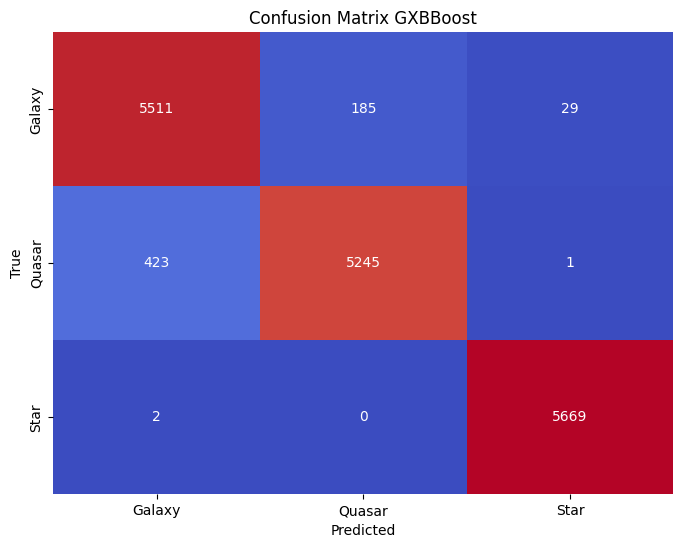

In [28]:
# create a label list for the class values
label_list = ['Galaxy', 'Quasar', 'Star']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix GXBBoost')
plt.show()


<div style="background-color:#eef9f1; border-left: 6px solid #8bc34a; padding: 10px;">
    <h3 style="color:#8bc34a;">Peronal Analysis</h3>
    <p style="font-size: 14px; color:#333;"> For training the Random Forest Model, I used the same dataset as training data. The model performance is very well with Star, only  misclassifications  to Galaxy. Galaxy and SQO have overlapping input features thats why model can not distinguish.</p>
</div>

In [26]:
# Classification report

# create label list for the class values
label_list = ['Galaxy', 'Quasar', 'Star']
print(classification_report(y_test, pred, target_names=label_list))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, pred)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

      Galaxy       0.93      0.96      0.95      5725
      Quasar       0.97      0.93      0.95      5669
        Star       0.99      1.00      1.00      5671

    accuracy                           0.96     17065
   macro avg       0.96      0.96      0.96     17065
weighted avg       0.96      0.96      0.96     17065


Model overall accuracy: 96.25%


<div style="background-color:#eef9f1; border-left: 6px solid #8bc34a; padding: 10px;">
    <h3 style="color:#8bc34a;">Peronal Analysis</h3>
    <p style="font-size: 14px; color:#333;">  The model performance is very well and with similar macro and weighted average, Star has hightest precision, recall and F1 than others, it means model can detect star easily.</p>
</div>